In [75]:
import sys
import cplex
from cplex.exceptions import CplexError
import numpy

num_sites_i = 1
num_scenarios_omega = 20
num_days_t = 365
num_daysPerMonth = 31
num_months_m = 12
num_lagdays_k = 2
num_prodays_u = 2

a = numpy.zeros((num_days_t, num_sites_i))   # Available supply per day by month
a[:,:] = 5000         # supply is unlimited by default
a[90:270, :] = 100    # supply from April to September is limited   

initialBiomassInventory = 123
initialEndProductInventory = 46

o_t = 400  # back order cost

# Demand (d_mu) adjustment factor by month
d_mu_adjustfactor = numpy.ones(num_days_t)
d_mu_adjustfactor[7*30: 9*30] = 2  # August, September  
d_mu_adjustfactor[9*30: 10*30] = 1.5  
d_mu_adjustfactor[10*30: 11*30] = 1.5
d_mu_adjustfactor[11*30:] = 1.5
d_mu_adjustfactor[0:2*30] = 1
d_mu_adjustfactor[2*30:4*30] = 1
d_mu_adjustfactor[4*30:8*30] = 0.5

rawToEndConversionRatio = 0.4
demand_mean=100
demand_std=20
demandScenario = numpy.zeros((num_scenarios_omega, num_days_t))
for omega in range(num_scenarios_omega):
    d = numpy.maximum(numpy.random.normal(demand_mean, demand_std, num_days_t),0)
    d = d*d_mu_adjustfactor
    demandScenario[omega,:]=d

In [76]:
my_obj = []
my_ub = []
my_colnames = []
my_varType = []

my_rhs = []
my_rownames = []
my_sense = ''

nonZero = []
irow=[]
icol=[]

col_US = numpy.zeros(num_months_m).astype(int)
col_LS = numpy.zeros(num_months_m).astype(int)

# N_(ω,t) whetehr we will order at period t
col_N_OT = numpy.zeros((num_scenarios_omega, num_days_t)).astype(int)
# R_(ω,t,i) whether order at period t from site i
col_R_OTI = numpy.zeros((num_scenarios_omega,num_days_t,num_sites_i)).astype(int)
# H_(ω,t) on hands inventory at period t
col_H_OT = numpy.zeros((num_scenarios_omega, num_days_t)).astype(int)
#L_(ω,t) end product at period t
col_L_OT = numpy.zeros((num_scenarios_omega, num_days_t)).astype(int)
#B_(ω,t) back order of end product at end of of period t
col_B_OT = numpy.zeros((num_scenarios_omega, num_days_t)).astype(int)
#Y_(ω,t,i) amount ordered 
col_Y_OTI = numpy.zeros((num_scenarios_omega,num_days_t,num_sites_i)).astype(int)
#I_(ω,t,k) amount in transition
col_I_OTK = numpy.zeros((num_scenarios_omega,num_days_t,num_lagdays_k)).astype(int)
#P_(ω,t)        
col_P_OT= numpy.zeros((num_scenarios_omega,num_days_t)).astype(int)
#Q_(ω,t,u)
col_Q_OTU= numpy.zeros((num_scenarios_omega,num_days_t,num_prodays_u)).astype(int)
#owned_(ω,t)
col_owned_OT= numpy.zeros((num_scenarios_omega,num_days_t)).astype(int)

my_prob = cplex.Cplex()
my_prob.objective.set_sense(my_prob.objective.sense.minimize)

# US_m, LS_m
num_var = 0
for idx_var in range(0,num_months_m):
    my_colnames.append('US_'+str(idx_var))
    my_obj.append (0)
    my_ub.append(cplex.infinity)
    my_varType.append('C')
    col_US[idx_var]=num_var
    num_var = num_var + 1    
    
    my_colnames.append('LS_'+str(idx_var))
    my_obj.append (0)
    my_ub.append(cplex.infinity)
    my_varType.append('C')
    col_LS[idx_var]=num_var
    num_var = num_var + 1
    
# N_(ω,t)
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        my_colnames.append('N_'+str(idx_var1)+'_'+str(idx_var2))
        my_obj.append (0)
        my_ub.append(cplex.infinity)
        my_varType.append('B')
        col_N_OT[idx_var1, idx_var2] =num_var
        num_var = num_var + 1
        
# R_(ω,t,i)
f_t_i = 10
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        for idx_var3 in range(num_sites_i):
            my_colnames.append('R_'+str(idx_var1)+'_'+str(idx_var2)+'_'+str(idx_var3))
            my_obj.append (f_t_i)
            my_ub.append(cplex.infinity)
            my_varType.append('B')
            col_R_OTI[idx_var1, idx_var2 ,idx_var3 ]=num_var 
            num_var = num_var + 1

# H_(ω,t)
s_t = 2
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        my_colnames.append('H_'+str(idx_var1)+'_'+str(idx_var2))
        my_obj.append (s_t)
        my_ub.append(cplex.infinity)
        my_varType.append('C')
        col_H_OT [idx_var1, idx_var2]=num_var
        num_var = num_var + 1        
        
# L_(ω,t)
w_t = 3
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        my_colnames.append('L_'+str(idx_var1)+'_'+str(idx_var2))
        my_obj.append (w_t)
        my_ub.append(cplex.infinity)
        my_varType.append('C')
        col_L_OT [idx_var1, idx_var2]=num_var
        num_var = num_var + 1
        
#B_(ω,t)
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        my_colnames.append('B_'+str(idx_var1)+'_'+str(idx_var2))
        my_obj.append (o_t)
        my_ub.append(cplex.infinity)
        my_varType.append('C')
        col_B_OT [idx_var1, idx_var2]=num_var
        num_var = num_var + 1
        
#Y_(ω,t,i)
c_t_i = 1
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        for idx_var3 in range(num_sites_i):
            my_colnames.append('Y_'+str(idx_var1)+'_'+str(idx_var2)+'_'+str(idx_var3))
            my_obj.append (c_t_i)
            my_ub.append(cplex.infinity)
            my_varType.append('C')
            col_Y_OTI[idx_var1, idx_var2,  idx_var3]=num_var
            num_var = num_var + 1

#I_(ω,t,k):
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        for idx_var3 in range(num_lagdays_k):
            my_colnames.append('I_'+str(idx_var1)+'_'+str(idx_var2)+'_'+str(idx_var3))
            my_obj.append (0)
            my_ub.append(cplex.infinity)
            my_varType.append('C')
            col_I_OTK[idx_var1,idx_var2,idx_var3]=num_var
            num_var = num_var + 1
                        
# P_(ω,t)
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        my_colnames.append('P_'+str(idx_var1)+'_'+str(idx_var2))
        my_obj.append (0)
        my_ub.append(cplex.infinity)
        my_varType.append('C')
        col_P_OT[idx_var1,idx_var2]=num_var
        num_var = num_var + 1
        
# Q _(ω,t,u)
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
        for idx_var3 in range(num_prodays_u):
            my_colnames.append('Q_'+str(idx_var1)+'_'+str(idx_var2)+'_'+str(idx_var3))
            my_obj.append (0)
            my_ub.append(cplex.infinity)
            my_varType.append('C')        
            col_Q_OTU[idx_var1,idx_var2,idx_var3]=num_var
            num_var = num_var + 1        
            
for idx_var1 in range(num_scenarios_omega):
    for idx_var2 in range(num_days_t):
            my_colnames.append('owned_'+str(idx_var1)+'_'+str(idx_var2))
            my_obj.append (0)
            my_ub.append(cplex.infinity)
            my_varType.append('C')        
            col_owned_OT[idx_var1,idx_var2]=num_var
            num_var = num_var + 1                    

my_obj = [i/num_scenarios_omega for i in my_obj]

my_prob.variables.add(obj=my_obj, ub=my_ub, names=my_colnames, types=my_varType)



range(0, 87624)

In [77]:
#Constraint (1.1); R_(ω,0,i)=0
#Constraint (1.2); M×R_(ω,t,i)-Y_(ω,t,i )≥0      
countNonZeros = 0
countnumRows = 0
for i in range (num_sites_i):
    for omg in range(num_scenarios_omega):

        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'L'
        my_rownames.append('Const11_'+str(omg)+str(0)+str(i))
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_R_OTI[omg,0,i])
        irow.append(countnumRows-1)

for t in range(1,num_days_t):
    for i in range (num_sites_i):
        for omg in range(num_scenarios_omega):

            countnumRows = countnumRows + 1
            my_rhs.append(0)
            my_sense=my_sense+'G'
            my_rownames.append('Const12_'+str(omg)+str(t)+str(i))
            countNonZeros = countNonZeros + 1
            nonZero.append(1000000)
            icol.append(col_R_OTI[omg,t,i])
            irow.append(countnumRows-1)

            countNonZeros = countNonZeros + 1
            nonZero.append(-1)
            icol.append(col_Y_OTI[omg,t,i])
            irow.append(countnumRows-1)

In [78]:
# Constratint (2.1) Y_(ω,0,i ) ≤ 0 
# Constratint (2.2) Y_(ω,t,i ) ≤ a_(t,i)     
for i in range (num_sites_i):
    for omg in range(num_scenarios_omega):
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'L'
        my_rownames.append('Const21_'+str(omg)+str(0)+str(i))

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_Y_OTI[omg,0,i])
        irow.append(countnumRows-1)

for t in range(1,num_days_t):
    for i in range (num_sites_i):
        for omg in range(num_scenarios_omega):

            countnumRows = countnumRows + 1
            my_rhs.append(a[t,i])
            my_sense=my_sense+'L'
            my_rownames.append('Const22_'+str(omg)+str(t)+str(i))
            
            countNonZeros = countNonZeros + 1
            nonZero.append(1)
            icol.append(col_Y_OTI[omg,t,i])
            irow.append(countnumRows-1)


In [79]:
# Constratint (3) 〖∑_i▒Y_(ω,t,i ) -P〗_(ω,t)=0   for t,ω   
for t in range(num_days_t):
    for omg in range(num_scenarios_omega):
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'E'
        my_rownames.append('Const3_'+str(omg)+str(t))        
        for i in range (num_sites_i):
            countNonZeros = countNonZeros + 1
            nonZero.append(1)
            icol.append(col_Y_OTI[omg,t,i])
            irow.append(countnumRows-1)        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_P_OT[omg,t])
        irow.append(countnumRows-1)

In [80]:
# Constratint (4)〖owned〗_(ω,t)-(H_(ω,t)+∑_(k≥2)▒I_(ω,t,k ) )=0  for t≥1,ω  
for t in range(num_days_t):
    for omg in range(num_scenarios_omega):
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'E'
        my_rownames.append('Const4_'+str(omg)+str(t))        

        for i in range (1,num_lagdays_k):
            countNonZeros = countNonZeros + 1
            nonZero.append(-1)
            icol.append(col_I_OTK[omg,t,i])
            irow.append(countnumRows-1)        
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_H_OT[omg,t])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_owned_OT[omg,t])
        irow.append(countnumRows-1)

In [81]:
# Constratint (5.1)  M×N_(ω,t)-〖LS〗_m+〖owned〗_(ω,t)>=0    
# Constratint (5.2)  M×N_(ω,t)-〖LS〗_m+〖owned〗_(ω,t)<=M
for t in range(1,num_days_t):
    for omg in range(num_scenarios_omega):
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'G'
        my_rownames.append('Const51_'+str(omg)+str(t))        

        countNonZeros = countNonZeros + 1
        nonZero.append(100000)
        icol.append(col_N_OT[omg,t])
        irow.append(countnumRows-1)        
        
        monthIdx = t//num_daysPerMonth
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_LS[monthIdx])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_owned_OT[omg,t])
        irow.append(countnumRows-1)
        
        # 5.2
        countnumRows = countnumRows + 1
        my_rhs.append(100000)
        my_sense=my_sense+'L'
        my_rownames.append('Const52_'+str(omg)+str(t))        

        countNonZeros = countNonZeros + 1
        nonZero.append(100000)
        icol.append(col_N_OT[omg,t])
        irow.append(countnumRows-1)        
        
        monthIdx = t//num_daysPerMonth
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_LS[monthIdx])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_owned_OT[omg,t])
        irow.append(countnumRows-1)
        

In [82]:
# Constratint (6.1) -P_(ω,t)+〖US〗_m-〖owned〗_(ω,t)-M*N_(ω,t)≤M    
# Constratint (6.2)  P_(ω,t)-〖US〗_m+〖owned〗_(ω,t)+M×N_(ω,t)≤M
# Constratint (6.3)  P_(ω,t)-M×N_(ω,t)≤0
for t in range(1,num_days_t):
    for omg in range(num_scenarios_omega):
        
        monthIdx = t//num_daysPerMonth

        # 6.1        
        countnumRows = countnumRows + 1
        my_rhs.append(100000)
        my_sense=my_sense+'L'
        my_rownames.append('Const61_'+str(omg)+str(t))        

        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_P_OT[omg,t])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(100000)
        icol.append(col_N_OT[omg,t])
        irow.append(countnumRows-1)        
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_US[monthIdx])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_owned_OT[omg,t])
        irow.append(countnumRows-1)
        
        # Constratint (6.2)  P_(ω,t)-〖US〗_m+〖owned〗_(ω,t)+M×N_(ω,t)≤M
        countnumRows = countnumRows + 1
        my_rhs.append(100000)
        my_sense=my_sense+'L'
        my_rownames.append('Const62_'+str(omg)+str(t))        

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_P_OT[omg,t])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(100000)
        icol.append(col_N_OT[omg,t])
        irow.append(countnumRows-1)        
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_US[monthIdx])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_owned_OT[omg,t])
        irow.append(countnumRows-1)
        
        # Constratint (6.3)  P_(ω,t)-M×N_(ω,t)≤0
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'L'
        my_rownames.append('Const63_'+str(omg)+str(t))      
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_P_OT[omg,t])
        irow.append(countnumRows-1)
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-100000)
        icol.append(col_N_OT[omg,t])
        irow.append(countnumRows-1)        

In [83]:
# Constratint (7.1) I_(ω,t,g)≤0                  for t=0,k=g,ω    
# Constratint (7.2) I_(ω,t,g)≤P_(ω,t)            for t≥1,k=g,ω    
# Constratint (7.3) I_(ω,t,k)= I_(ω,t-1,k+1)     for t≥2,k≤g-1,ω
for omg in range(num_scenarios_omega):
    for k in range(num_lagdays_k-1):
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'L'
        my_rownames.append('Const71_'+str(omg)+str(0)+str(k))      

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_I_OTK[omg,0,k])
        irow.append(countnumRows-1)  

for t in range(1,num_days_t):
    for omg in range(num_scenarios_omega):
        # 7.1
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'E'
        my_rownames.append('Const72_'+str(omg)+str(t)+str(num_lagdays_k-1))      

        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_P_OT[omg,t])
        irow.append(countnumRows-1)

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_I_OTK[omg,t,num_lagdays_k-1])
        irow.append(countnumRows-1)  

# Constratint (7.2) I_(ω,t,k)= I_(ω,t-1,k+1)     for t≥2,k≤g-1,ω
for t in range(2,num_days_t):
    for omg in range(num_scenarios_omega):
        for k in range(num_lagdays_k-1):
            
            countnumRows = countnumRows + 1
            my_rhs.append(0)
            my_sense=my_sense+'E'
            my_rownames.append('Const73_'+str(omg)+str(t)+str(k))      

            countNonZeros = countNonZeros + 1
            nonZero.append(1)
            icol.append(col_I_OTK[omg,t,k])
            irow.append(countnumRows-1)  

            countNonZeros = countNonZeros + 1
            nonZero.append(-1)
            icol.append(col_I_OTK[omg,t-1,k+1])
            irow.append(countnumRows-1)  


In [84]:
# Constratint (8.1) H_(ω,0)=h_0        
# Constratint (8.2) H_(ω,t)-H_(ω,t-1)+Q_(ω,t,e)-I_(ω,t-1,1)=0  for all t≥1,k=1,u=e,ω

for omg in range(num_scenarios_omega):
    # 8.1
    countnumRows = countnumRows + 1
    my_rhs.append(initialBiomassInventory)
    my_sense=my_sense+'E'
    my_rownames.append('Const81_'+str(omg)+str(0))      

    countNonZeros = countNonZeros + 1
    nonZero.append(1)
    icol.append(col_H_OT[omg,0])
    irow.append(countnumRows-1)

# Constratint Constratint (8.2) H_(ω,t)-H_(ω,t-1)+Q_(ω,t,e)-I_(ω,t-1,1)=0  for all t≥1,k=1,u=e,ω
u = num_prodays_u-1
k=0
for t in range(1,num_days_t):
    for omg in range(num_scenarios_omega):
        
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'E'
        my_rownames.append('Const82_'+str(omg)+str(t)+str(k)+str(u))      

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_H_OT[omg,t])
        irow.append(countnumRows-1)  
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_H_OT[omg,t-1])
        irow.append(countnumRows-1)  
        
        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_Q_OTU[omg,t,u])
        irow.append(countnumRows-1)  
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_I_OTK[omg,t-1,k])
        irow.append(countnumRows-1)  


In [85]:
# Constratint Constratint (9) Q_(ω,t,u)=Q_(ω,t-1,u+1)      for t≥2,u≤e-1,ω

for omg in range(num_scenarios_omega):
    for u in range(num_prodays_u):     
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'E'
        my_rownames.append('Const91_'+str(omg)+str(t)+str(u))      

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_Q_OTU[omg,0,u])
        irow.append(countnumRows-1)  

for t in range(1,num_days_t):
    for omg in range(num_scenarios_omega):
        for u in range(num_prodays_u-1):     
            countnumRows = countnumRows + 1
            my_rhs.append(0)
            my_sense=my_sense+'E'
            my_rownames.append('Const92_'+str(omg)+str(t)+str(u))      

            countNonZeros = countNonZeros + 1
            nonZero.append(1)
            icol.append(col_Q_OTU[omg,t,u])
            irow.append(countnumRows-1)  

            countNonZeros = countNonZeros + 1
            nonZero.append(-1)
            icol.append(col_Q_OTU[omg,t-1,u+1])
            irow.append(countnumRows-1)  

In [86]:
# Constratint Constratint (10.1) L_(ω,0)=l_0   t=0,ω
for omg in range(num_scenarios_omega):
    # 10.1
    countnumRows = countnumRows + 1
    my_rhs.append(initialEndProductInventory)
    my_sense=my_sense+'E'
    my_rownames.append('Const101_'+str(omg)+str(0))      

    countNonZeros = countNonZeros + 1
    nonZero.append(1)
    icol.append(col_L_OT[omg,0])
    irow.append(countnumRows-1)
    
# Constratint Constratint (10.2) L_(ω,t)=L_(ω,t-1)+B_(ω,t)+r×Q_(ω,t-1,u=1)-d_(ω,t)  for t≥1,ω
u=0
for t in range(1,num_days_t):
    for omg in range(num_scenarios_omega):
        countnumRows = countnumRows + 1
        my_rhs.append(-demandScenario[omg,t])
        my_sense=my_sense+'E'
        my_rownames.append('Const102_'+str(omg)+str(t)+str(u))      

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_L_OT[omg,t])
        irow.append(countnumRows-1)  

        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_L_OT[omg,t-1])
        irow.append(countnumRows-1)  

        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_B_OT[omg,t])
        irow.append(countnumRows-1)  

        countNonZeros = countNonZeros + 1
        nonZero.append(-rawToEndConversionRatio)
        icol.append(col_Q_OTU[omg,t,u])
        irow.append(countnumRows-1)  

In [87]:
# Constratint (11)     
num_month = num_days_t//num_daysPerMonth
for m in range(num_month):
        countnumRows = countnumRows + 1
        my_rhs.append(0)
        my_sense=my_sense+'G'
        my_rownames.append('Cons_11_'+str(m))        

        countNonZeros = countNonZeros + 1
        nonZero.append(1)
        icol.append(col_US[m])
        irow.append(countnumRows-1)        
        
        countNonZeros = countNonZeros + 1
        nonZero.append(-1)
        icol.append(col_LS[m])
        irow.append(countnumRows-1)

In [88]:
len(nonZero)

276862

In [ ]:
# Reorganize all non zeros
irow = [int(item) for item in irow]
icol = [int(item) for item in icol]

my_prob.linear_constraints.add(rhs=my_rhs, senses=my_sense, names=my_rownames)
my_prob.linear_constraints.set_coefficients(zip(irow, icol, nonZero))

my_prob.parameters.mip.tolerances.mipgap.set(float(0.05))  
#my_prob.write("IMex1.lp")
my_prob.solve()

numrows = my_prob.linear_constraints.get_num()
numcols = my_prob.variables.get_num()

CPXPARAM_Read_DataCheck                          1
CPXPARAM_MIP_Tolerances_MIPGap                   0.050000000000000003


Tried aggregator 3 times.
MIP Presolve eliminated 7580 rows and 440 columns.
MIP Presolve modified 14700 coefficients.
Aggregator did 35740 substitutions.
Reduced MIP has 58771 rows, 51444 columns, and 204142 nonzeros.
Reduced MIP has 14560 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.48 sec. (6438.95 ticks)
Found incumbent of value 1.5142868e+07 after 0.72 sec. (6595.30 ticks)
Probing fixed 0 vars, tightened 33135 bounds.
Probing time = 1.34 sec. (592.59 ticks)
Tried aggregator 1 time.
MIP Presolve modified 600 coefficients.
Reduced MIP has 58771 rows, 51444 columns, and 204142 nonzeros.
Reduced MIP has 14560 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.33 sec. (1940.25 ticks)
Probing fixed 0 vars, tightened 36661 bounds.
Probing time = 0.50 sec. (311.24 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.97 sec. (946.

   2083   100  2597668.7757  9310  2994719.0209  2596884.3667   330338   13.28%
   2127   104  2597731.5585  9305  2994719.0209  2596884.3667   331408   13.28%
   2175   110  2598709.7445  9283  2994719.0209  2596884.3667   333960   13.28%
   2214   188  2599407.4415  9277  2994719.0209  2596884.3667   355957   13.28%
   2262   220  2600329.5545  9224  2994719.0209  2596884.3667   364891   13.28%
   2313   230  2601217.4374  9201  2994719.0209  2596884.3667   367260   13.28%
   2368   260  2601020.8230  9201  2994719.0209  2596884.3667   375441   13.28%
   2415   369  2602302.3214  9197  2994719.0209  2596884.3667   409803   13.28%
   2440   352  2597939.5900  9224  2994719.0209  2596884.3667   406227   13.28%
Elapsed time = 518.22 sec. (311604.93 ticks, tree = 11.69 MB, solutions = 15)
   2474   409  2605523.6531  9143  2994719.0209  2596884.3667   421479   13.28%
   2498   418  2602793.6529  9254  2994719.0209  2596884.3667   428128   13.28%
   2533   524  2606599.8732  9124  2994719

  26581 23924  2784097.2975  8475  2994719.0209  2597105.2658  1810544   13.28%


In [37]:
import pandas as pd

pd.set_option('display.max_rows', None)

print("Solution status = ", my_prob.solution.get_status(), ":", end=' ')
print(my_prob.solution.status[my_prob.solution.get_status()])
print("Solution value  = ", my_prob.solution.get_objective_value())
x = my_prob.solution.get_values()

solution_list=[]
for j in range(numcols):
    solution_list.append([j, my_colnames[j], x[j]])

df = pd.DataFrame (solution_list, columns = ['var_index', 'var_name', 'var_value'])

Solution status =  102 : optimal_tolerance
Solution value  =  2802265.1063555405


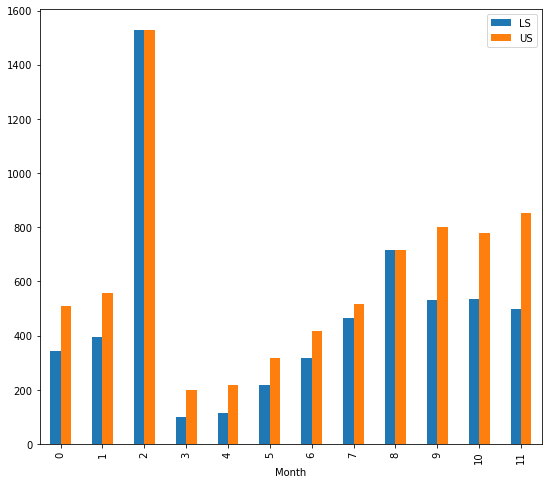

In [71]:
import matplotlib.pyplot as plt

df_policy = df[df['var_name'].str.startswith('US') | df['var_name'].str.startswith('LS')]

df_policy[['var_prefix', 'month']] = df_policy['var_name'].str.split(pat='_', expand=True)

df_policy_US = df_policy[df_policy['var_prefix']=='US']
df_policy_LS = df_policy[df_policy['var_prefix']=='LS']

df_policy_US.rename(columns = {'var_value':'Order up to'}, inplace = True)
df_policy_LS.rename(columns = {'var_value':'Order if bellow'}, inplace = True)

df_policy_US=df_policy_US.reset_index()
df_policy_LS=df_policy_LS.reset_index()

df_up_low = pd.DataFrame(columns=['Month', 'LS', 'US'])
df_up_low['Month'] = df_policy_US['month']
df_up_low['US'] = df_policy_US['Order up to']
df_up_low['LS'] = df_policy_LS['Order if bellow']

df_up_low.plot(x="Month", y=['LS','US'], kind="bar", figsize=(9, 8))
plt.show()

C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

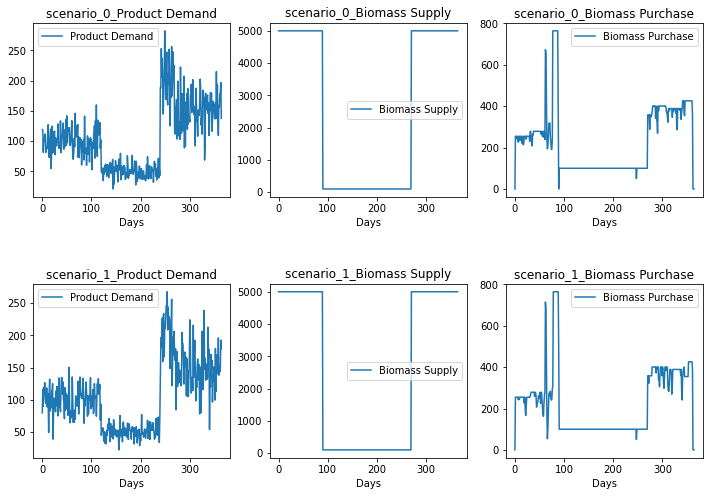

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

itemsToPlot =['Product Demand','Biomass Supply', "Biomass Purchase"]

df_p_purchase = df[df['var_name'].str.startswith('P')]
df_p_purchase[['var_prefix', 'scenario', 'day']] = df_p_purchase['var_name'].str.split(pat='_', expand=True)
df_p_purchase.rename(columns = {'var_value':'Biomass Purchase'}, inplace = True)

indexPlot =1
for idxScenario in range(num_scenarios_omega):
    
    df_omega_purchase =  df_p_purchase[df_p_purchase["scenario"]==str(idxScenario)]
    df_omega_purchase['Product Demand'] = demandScenario[idxScenario,:]
    df_omega_purchase['Biomass Supply'] = a
    df_omega_purchase.set_index('day')
    
    for item in itemsToPlot:
        
        # add a new subplot iteratively
        ax = plt.subplot(num_scenarios_omega, len(itemsToPlot), indexPlot)
        df_omega_purchase.plot(ax=ax, x='day', y =item)

        # chart formatting
        ax.set_title("scenario_" + str(idxScenario)+'_'+str(item))
        ax.set_xlabel("Days")

        indexPlot = indexPlot +1

plt.show()    

C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


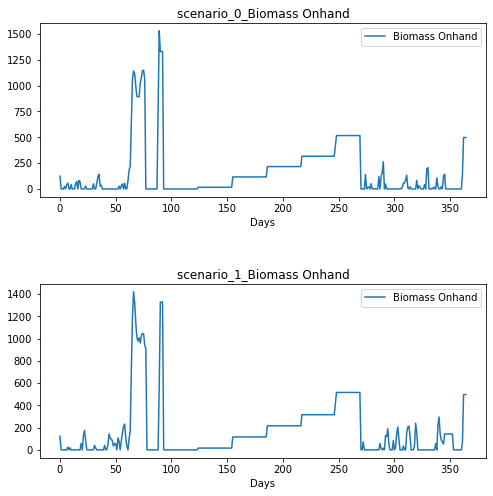

In [67]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)

itemsToPlot =["Biomass Onhand"]

df_p_onhand = df[df['var_name'].str.startswith('H')]
df_p_onhand[['var_prefix', 'scenario', 'day']] = df_p_onhand['var_name'].str.split(pat='_', expand=True)
df_p_onhand.rename(columns = {'var_value':"Biomass Onhand"}, inplace = True)

indexPlot =1
for idxScenario in range(num_scenarios_omega):
    
    df_omega_purchase =  df_p_onhand[df_p_onhand["scenario"]==str(idxScenario)]
    df_omega_purchase.set_index('day')
    
    for item in itemsToPlot:
        
        # add a new subplot iteratively
        ax = plt.subplot(num_scenarios_omega, len(itemsToPlot), indexPlot)
        df_omega_purchase.plot(ax=ax, x='day', y =item)

        # chart formatting
        ax.set_title("scenario_" + str(idxScenario)+'_'+str(item))
        ax.set_xlabel("Days")

        indexPlot = indexPlot +1

plt.show()
    


C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\wei\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


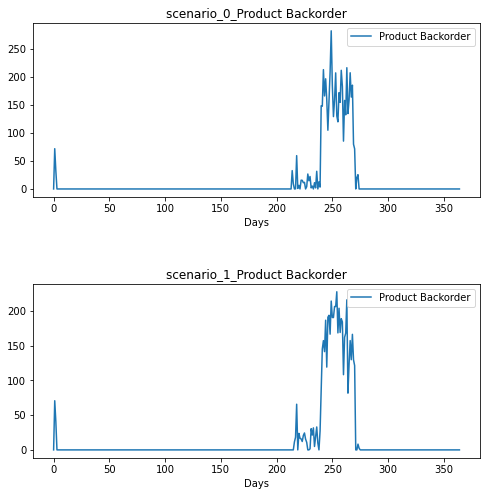

In [68]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)

itemsToPlot =["Product Backorder"]

df_p_onhand = df[df['var_name'].str.startswith('B')]
df_p_onhand[['var_prefix', 'scenario', 'day']] = df_p_onhand['var_name'].str.split(pat='_', expand=True)
df_p_onhand.rename(columns = {'var_value':"Product Backorder"}, inplace = True)

indexPlot =1
for idxScenario in range(num_scenarios_omega):
    
    df_omega_purchase =  df_p_onhand[df_p_onhand["scenario"]==str(idxScenario)]
    df_omega_purchase.set_index('day')
    
    for item in itemsToPlot:
        
        # add a new subplot iteratively
        ax = plt.subplot(num_scenarios_omega, len(itemsToPlot), indexPlot)
        df_omega_purchase.plot(ax=ax, x='day', y =item)

        # chart formatting
        ax.set_title("scenario_" + str(idxScenario)+'_'+str(item))
        ax.set_xlabel("Days")

        indexPlot = indexPlot +1

plt.show()
    

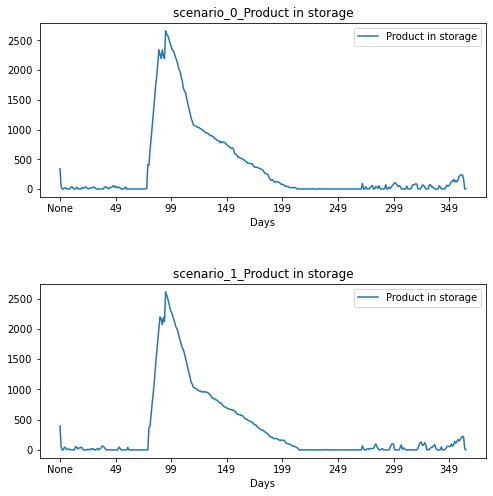

In [73]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)

itemsToPlot =["Product in storage"]

df_p_onhand = df[df['var_name'].str.startswith('L')]
df_p_onhand[['var_prefix', 'scenario', 'day']] = df_p_onhand['var_name'].str.split(pat='_', expand=True)
df_p_onhand.rename(columns = {'var_value':"Product in storage"}, inplace = True)

indexPlot =1
for idxScenario in range(num_scenarios_omega):
    
    df_omega_purchase =  df_p_onhand[df_p_onhand["scenario"]==str(idxScenario)]
    df_omega_purchase.set_index('day')
    
    for item in itemsToPlot:
        
        # add a new subplot iteratively
        ax = plt.subplot(num_scenarios_omega, len(itemsToPlot), indexPlot)
        df_omega_purchase.plot(ax=ax, x='day', y =item)

        # chart formatting
        ax.set_title("scenario_" + str(idxScenario)+'_'+str(item))
        ax.set_xlabel("Days")

        indexPlot = indexPlot +1

plt.show()
    

In [74]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)

itemsToPlot =["Product in storage"]

df_p_onhand = df[df['var_name'].str.startswith('Q')]
df_p_onhand[['var_prefix', 'scenario', 'day', 'day']] = df_p_onhand['var_name'].str.split(pat='_', expand=True)
df_p_onhand.rename(columns = {'var_value':"Product in storage"}, inplace = True)


df_p_onhand

,var_index,var_name,var_value
6594,6594,Q_0_0_0,0.000000
6595,6595,Q_0_0_1,0.000000
6596,6596,Q_0_1_0,0.000000
6597,6597,Q_0_1_1,123.000000
6598,6598,Q_0_2_0,123.000000
6599,6599,Q_0_2_1,296.878426
6600,6600,Q_0_3_0,296.878426
6601,6601,Q_0_3_1,254.748336
6602,6602,Q_0_4_0,254.748336
6603,6603,Q_0_4_1,229.929699


<Figure size 576x576 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)

itemsToPlot =["Product in storage"]

df_p_onhand = df[df['var_name'].str.startswith('Q')]
df_p_onhand[['var_prefix', 'scenario', 'day']] = df_p_onhand['var_name'].str.split(pat='_', expand=True)
df_p_onhand.rename(columns = {'var_value':"Product in storage"}, inplace = True)

indexPlot =1
for idxScenario in range(num_scenarios_omega):
    
    df_omega_purchase =  df_p_onhand[df_p_onhand["scenario"]==str(idxScenario)]
    df_omega_purchase.set_index('day')
    
    for item in itemsToPlot:
        
        # add a new subplot iteratively
        ax = plt.subplot(num_scenarios_omega, len(itemsToPlot), indexPlot)
        df_omega_purchase.plot(ax=ax, x='day', y =item)

        # chart formatting
        ax.set_title("scenario_" + str(idxScenario)+'_'+str(item))
        ax.set_xlabel("Days")

        indexPlot = indexPlot +1

plt.show()